In [1]:
import matplotlib.pyplot as plt
import pandas  as pd
import numpy   as np
import xgboost as xgb

In [2]:
dg_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv')
dg_df.head(16)

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


In [3]:
df = pd.read_csv(r'./normalized_features.csv', sep='\t', encoding='utf-8')

In [4]:
df = df.dropna().drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [5]:
df.isna().sum()

calories2hr       0
protein2hr        0
sugar2hr          0
carbs2hr          0
calories8hr       0
                 ..
datetime          0
ID                0
HbA1c             0
Biological Sex    0
label             0
Length: 155, dtype: int64

In [6]:
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

In [7]:
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh':2})

In [8]:
corrdf = df.drop(columns=['datetime']).corr()

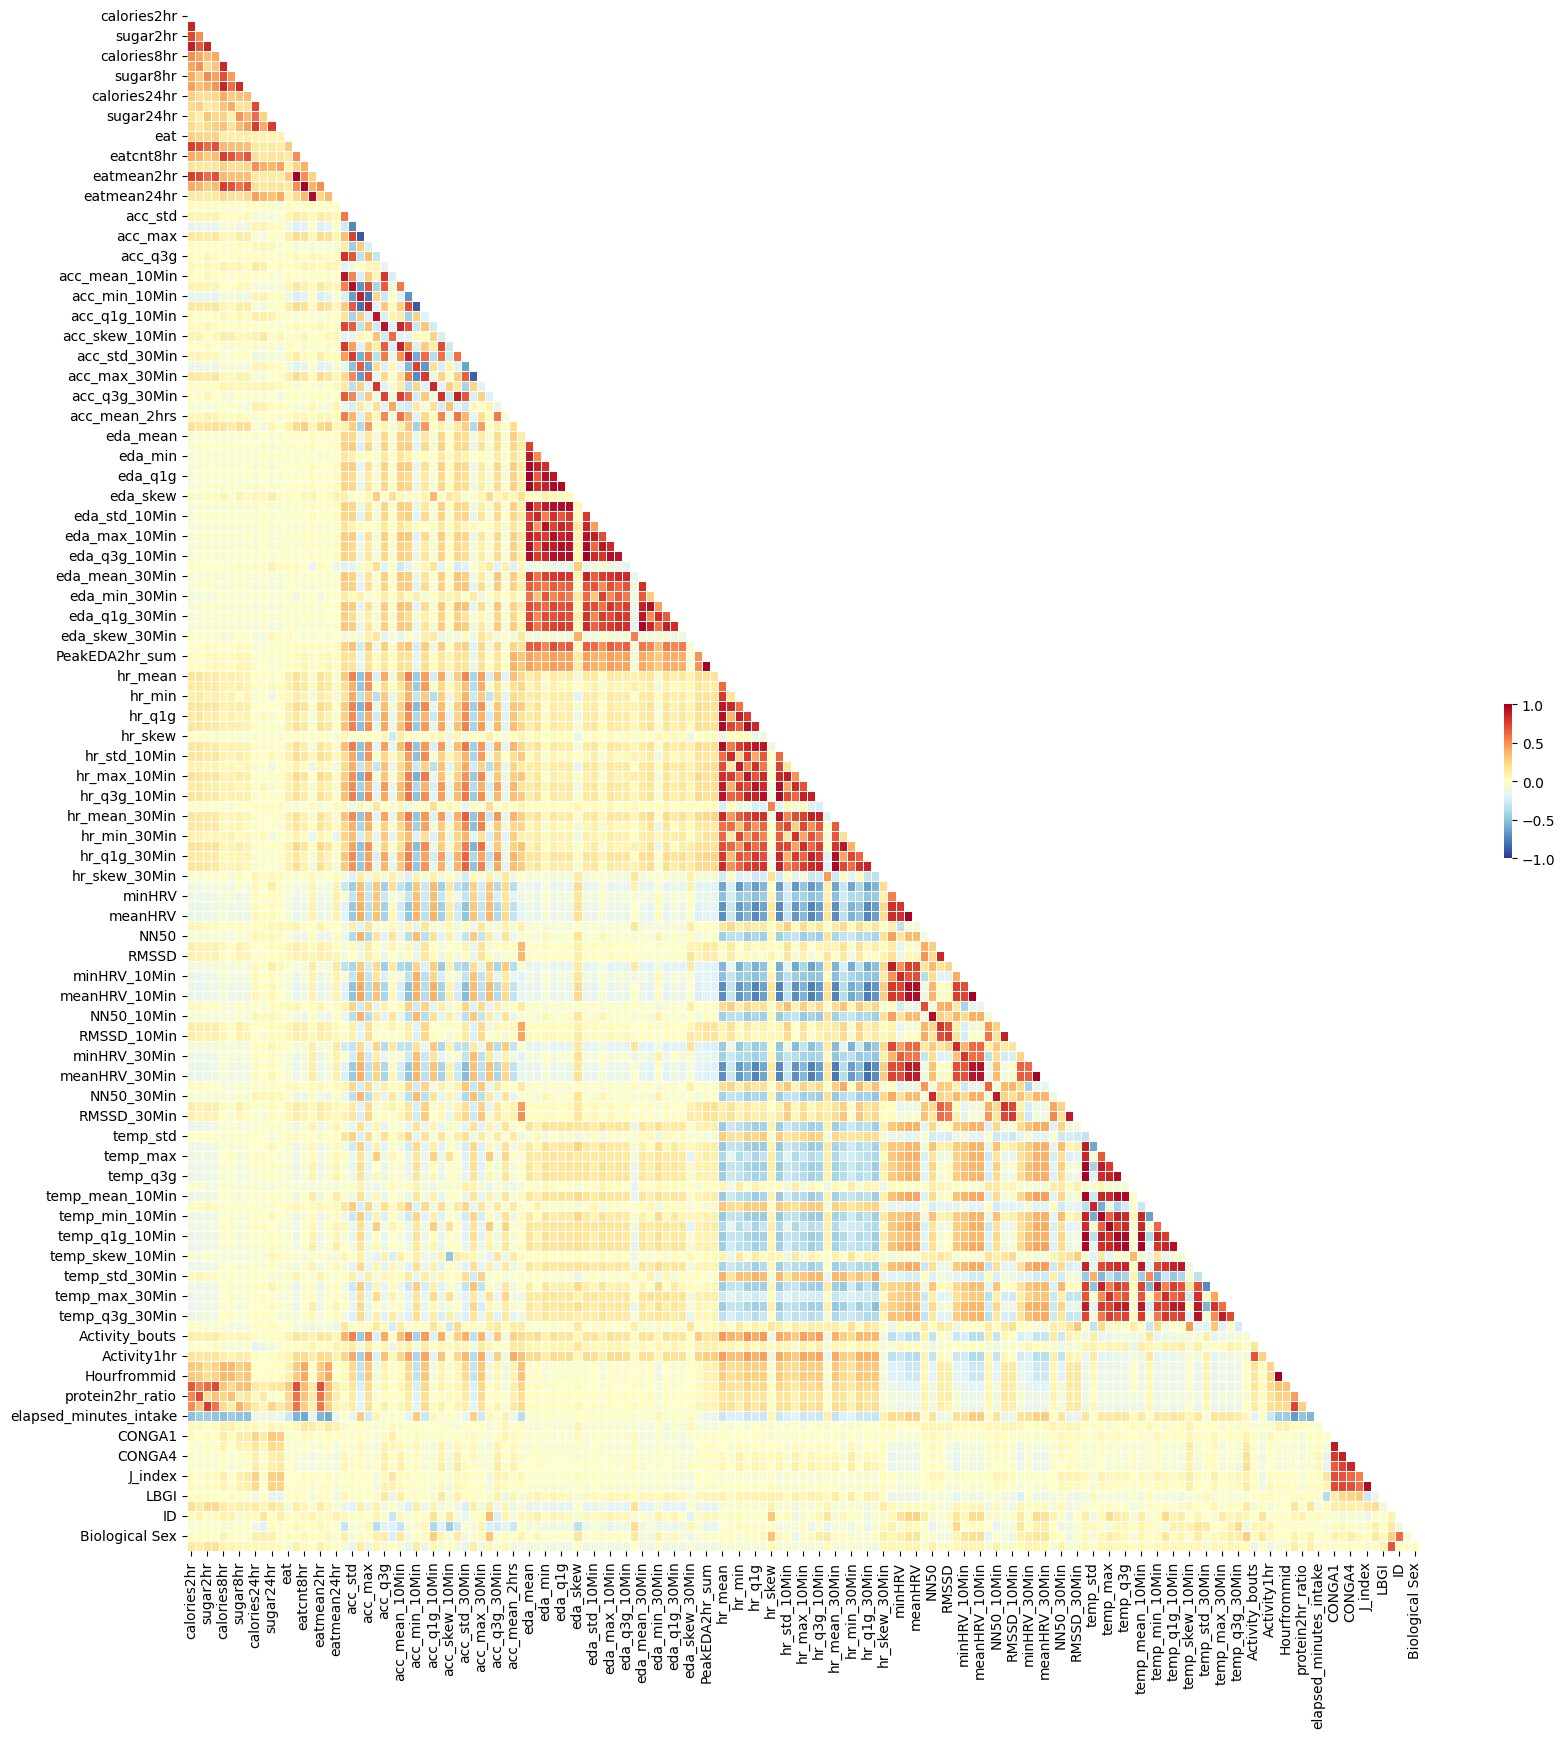

In [9]:
import seaborn as sns

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(20,20) )

mask = np.zeros_like(corrdf)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(corrdf, 
            cmap = 'RdYlBu_r', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .1},# 컬러바 크기 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

## 1. 독립적 교차 검증(subject-independent cross-validation), LOSO(Leave-One-Subject-Out) Model

In [10]:
def XGBLOSO(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000):
    """
        Intermediate function. 
    """
    # Get important features
    #listimportances = LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators)
    #filteredi = listimportances[listimportances['importances'] < fs]
    #filteredi = filteredi['value']
    
    LOOCV_O = int(float(ids))
    data.loc[:,idcolumn] = data.loc[:,idcolumn].apply(int)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')
    
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    #data_test = data_test.drop(columns=filteredi) #cvf
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable

    #X_test.loc[:, idcolumn] = X_test.loc[:, idcolumn].astype(pd.to_numeric)
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    #data_train = data_train.drop(columns=filteredi)
    X_train = data_train.drop(columns=[outcomevar])

    feature_list = list(X_train.columns)
    #X_train= X_train
    y_train = data_train[outcomevar]

    #X_train.loc[:, idcolumn] = X_train.loc[:, idcolumn].astype(pd.to_numeric)


    # XGBoost Regressor with fixed parameters
    xgbr = xgb.XGBRegressor(
        n_estimators=numestimators,
        max_depth=6,
        learning_rate=0.1,
        random_state=0,
        enable_categorical=True
    )
    print('Now processing... XGBoost - Leave One Subject Out')
    xgbr.fit(X_train, y_train)
    
    test_predictions = xgbr.predict(X_test)
    train_predictions = xgbr.predict(X_train)
    errors = abs(test_predictions - y_test)

    # Root Mean Squared Error (RMSE)
    from sklearn import metrics
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, test_predictions))
    test_rmse = RMSE
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_predictions))
    train_r2 = metrics.r2_score(y_train, train_predictions)
    test_r2 = metrics.r2_score(y_test, test_predictions)
    
    # Mean Average Percent Error (MAPE)
    MAPerror = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100 
    test_mape = MAPerror
    train_mape = np.mean(np.abs((y_train - train_predictions) / y_train)) * 100 
    
    # List of tuples with variable and importance
    importances = list(xgbr.feature_importances_)
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    important['id'] = str(ids)
    
    return train_rmse, test_rmse, train_mape, test_mape, train_r2, test_r2, errors, RMSE, MAPerror, test_r2, important

def losoXGB(data, idcolumn, outcomevar, dropcols=[], numestimators=1000):
    """
        Main LOSO XGB function that calls other functions to do XGB training, and testing. 

        Args:
          
        Returns:
    """
    
    # Make list of all ID's in idcolumn
    IDlist = list(data[idcolumn].astype(str).unique())
    print(f'IDlist : {IDlist}')
    drop = [] #drop = [idcolumn]
    drop = drop + dropcols
    
    # Initialize empty lists and dataframe 
    errors = []
    rmse = []
    mape = []
    r2_list = []
    importances = pd.DataFrame(columns=['value', 'importances', 'id'])
    rmse_df = pd.DataFrame(columns=['train_rmse','test_rmse', 'id'])
    mape_df = pd.DataFrame(columns=['train_mape','test_mape', 'id'])
    acc_df = pd.DataFrame(columns=['train_acc','test_acc', 'id'])
    r2_df = pd.DataFrame(columns=['train_r2','test_r2', 'id'])
    
    # Run LOOCV Random Forest! 
    for i in IDlist:
        train_rmse, test_rmse, train_mape, test_mape, train_r2, test_r2, er, rm, ma, r2, imp= XGBLOSO(data, i, outcomevar, drop, idcolumn, numestimators)
        rmse_row = pd.DataFrame({'train_rmse': [train_rmse], 'test_rmse': [test_rmse], 'id': [str(i)]})
        rmse_df = pd.concat([rmse_df, rmse_row], ignore_index=True)
        mape_row = pd.DataFrame({'train_mape': [train_mape], 'test_mape': [test_mape], 'id': [str(i)]})
        mape_df = pd.concat([mape_df, mape_row], ignore_index=True)
        acc_row = pd.DataFrame({'train_acc': [100 - train_mape], 'test_acc': [100 - test_mape], 'id': [str(i)]})
        acc_df = pd.concat([acc_df, acc_row], ignore_index=True)
        r2_row = pd.DataFrame({'train_r2': [train_r2], 'test_r2': [test_r2], 'id': [str(i)]})
        r2_df = pd.concat([r2_df, r2_row], ignore_index=True)
        errors.append(er)
        rmse.append(rm)
        mape.append(ma)
        r2_list.append(r2)
        #eval = pd.DataFrame({'rmse': [rm], 'mape': [ma], 'id': [str(i)]})
        #eval_metrics = pd.concat([eval_metrics, eval], ignore_index=True)
        importances = pd.concat([importances, imp], ignore_index=True)
        idt = str(i)
        print('...' + idt + ' processing complete.')

    # Compute mean and std RMSE, MAPE
    meanrmse = np.mean(rmse)
    stdrmse = np.std(rmse)
    meanmape = np.mean(mape)
    stdmape = np.std(mape)
    meanr2 = np.mean(r2_list)
    stdr2 = np.std(r2_list)
    
    # Print RMSE, MAPE
    print('Mean RMSE:' + str(meanrmse))
    print('Std RMSE:' + str(stdrmse))
    print('Mean MAPE:' + str(meanmape))
    print('Std MAPE:' + str(stdmape))
    print('Mean R2:' + str(meanr2))
    print('Std R2:' + str(stdr2))
    
    eval_df = rmse_df.merge(mape_df, on='id').merge(acc_df, on='id').merge(r2_df, on='id')
    
    #TODO: 파라미터들을 담은 dataframe을 반환하도록 할 것.
    return eval_df, errors, meanrmse, stdrmse, meanmape, stdmape, importances

In [11]:
eval_df, errors, RMSE, RMSEstd, MAPE, MAPEstd, importances = losoXGB(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'], numestimators=100)

IDlist : ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '16.0']
LOOCV_O : 1
Now processing... XGBoost - Leave One Subject Out


/tmp/ipykernel_843/3746877047.py:104: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmse_df = pd.concat([rmse_df, rmse_row], ignore_index=True)
/tmp/ipykernel_843/3746877047.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mape_df = pd.concat([mape_df, mape_row], ignore_index=True)
/tmp/ipykernel_843/3746877047.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns wh

...1.0 processing complete.
LOOCV_O : 2
Now processing... XGBoost - Leave One Subject Out
...2.0 processing complete.
LOOCV_O : 3
Now processing... XGBoost - Leave One Subject Out
...3.0 processing complete.
LOOCV_O : 4
Now processing... XGBoost - Leave One Subject Out
...4.0 processing complete.
LOOCV_O : 5
Now processing... XGBoost - Leave One Subject Out
...5.0 processing complete.
LOOCV_O : 6
Now processing... XGBoost - Leave One Subject Out
...6.0 processing complete.
LOOCV_O : 7
Now processing... XGBoost - Leave One Subject Out
...7.0 processing complete.
LOOCV_O : 8
Now processing... XGBoost - Leave One Subject Out
...8.0 processing complete.
LOOCV_O : 9
Now processing... XGBoost - Leave One Subject Out
...9.0 processing complete.
LOOCV_O : 10
Now processing... XGBoost - Leave One Subject Out
...10.0 processing complete.
LOOCV_O : 11
Now processing... XGBoost - Leave One Subject Out
...11.0 processing complete.
LOOCV_O : 12
Now processing... XGBoost - Leave One Subject Out
...12

In [12]:
eval_df.head(20)

,train_rmse,test_rmse,id,train_mape,test_mape,train_acc,test_acc,train_r2,test_r2
0,7.100179,23.015302,1.0,4.543487,18.529340,95.456513,81.470660,0.910356,-1.233602
1,6.725626,24.454146,2.0,4.383656,14.811676,95.616344,85.188324,0.915634,-0.524421
2,6.754475,18.349094,3.0,4.339808,12.982923,95.660192,87.017077,0.917876,-0.150435
3,7.001162,17.782231,4.0,4.493009,12.540845,95.506991,87.459155,0.912057,0.011392
4,7.200921,14.649914,5.0,4.590570,11.980005,95.409430,88.019995,0.907467,-0.157151
5,6.915658,32.399152,6.0,4.436705,15.648310,95.563295,84.351690,0.905251,-0.207120
6,7.304299,27.087733,7.0,4.603157,28.212156,95.396843,71.787844,0.897439,-1.226143
7,7.139744,13.074487,8.0,4.576752,8.543619,95.423248,91.456381,0.909938,0.304279
8,7.151980,21.468246,9.0,4.621107,12.425123,95.378893,87.574877,0.903843,0.147775
9,7.024330,27.643760,10.0,4.498445,17.015407,95.501555,82.984593,0.905421,0.084436


In [13]:
# Compute average of RMSE
avg_train_rmse = eval_df['train_rmse'].mean()
avg_test_rmse = eval_df['test_rmse'].mean()
# Compute average of MAPE
avg_train_mape = eval_df['train_acc'].mean()
avg_test_mape = eval_df['test_acc'].mean()
# Compute average of MAPE
avg_train_r2 = eval_df['train_r2'].mean()
avg_test_r2 = eval_df['test_r2'].mean()

In [14]:
imp_err = importances.groupby('value').std(numeric_only=True).rename(columns={'importances':'std'})

In [15]:
filteredimp = importances.groupby('value').mean(numeric_only=True).sort_values(by='importances', ascending=False)
filteredimp = pd.merge(filteredimp, imp_err, on='value')
print(filteredimp)

                 importances       std
value                                 
Biological Sex      0.094359  0.037821
HbA1c               0.056328  0.023255
PeakEDA2hr_mean     0.036274  0.022302
ID                  0.028923  0.007061
carbs2hr            0.024590  0.002984
...                      ...       ...
pNN50               0.002124  0.001038
eat                 0.002029  0.002850
eda_min_10Min       0.001765  0.000587
acc_mean            0.001533  0.000313
Activity_bouts      0.001153  0.001089

[152 rows x 2 columns]


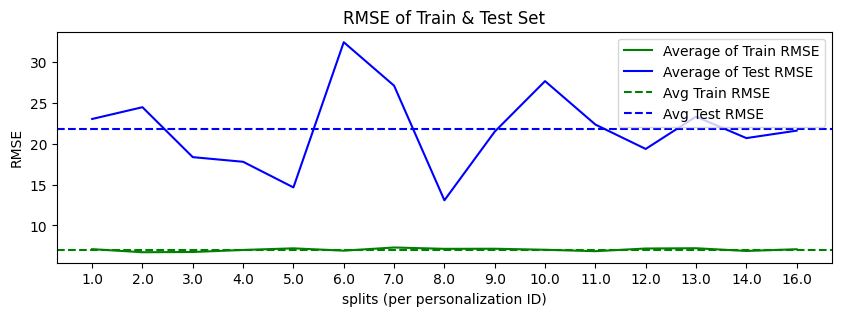

In [16]:
# 그래프 그리기
plt.figure(figsize=(10, 3))
plt.plot(eval_df['id'], eval_df['train_rmse'], 'g', label='Average of Train RMSE')
plt.plot(eval_df['id'], eval_df['test_rmse'], 'b', label='Average of Test RMSE')

# 가로 점선 추가
plt.axhline(y=avg_train_rmse, color='g', linestyle='--', label='Avg Train RMSE')
plt.axhline(y=avg_test_rmse, color='b', linestyle='--', label='Avg Test RMSE')

plt.title('RMSE of Train & Test Set')
plt.xlabel('splits (per personalization ID)')
plt.ylabel('RMSE')
plt.legend()

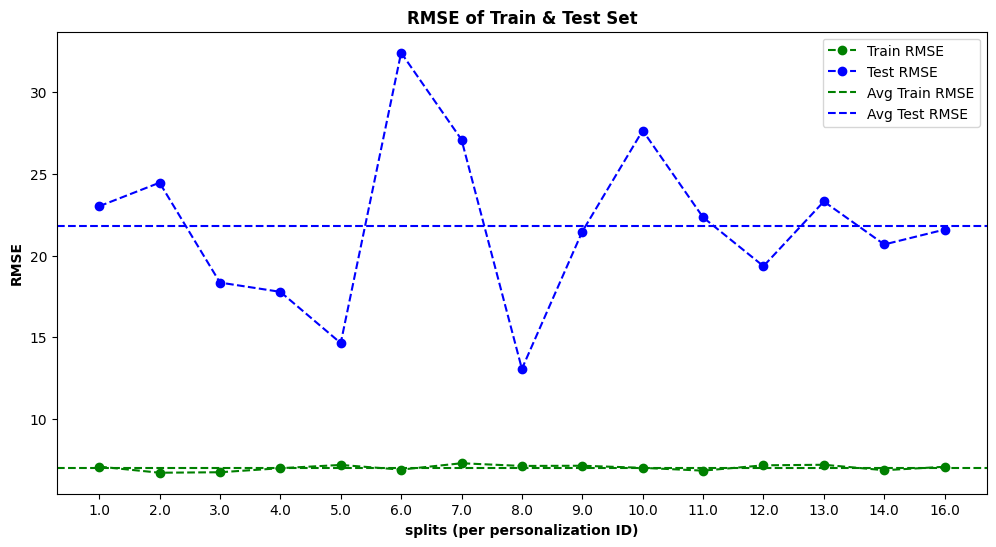

In [17]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(eval_df['id'], eval_df['train_rmse'], 'go--', label='Train RMSE')
plt.plot(eval_df['id'], eval_df['test_rmse'], 'bo--', label='Test RMSE')

# 가로 점선 추가 (평균값 표시)
plt.axhline(y=avg_train_rmse, color='g', linestyle='--', label='Avg Train RMSE')
plt.axhline(y=avg_test_rmse, color='b', linestyle='--', label='Avg Test RMSE')

# 레이블 및 제목 설정
plt.xlabel('splits (per personalization ID)', fontweight='bold')
plt.ylabel('RMSE', fontweight='bold')
plt.title('RMSE of Train & Test Set', fontweight='bold')
plt.xticks(eval_df['id'])

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()


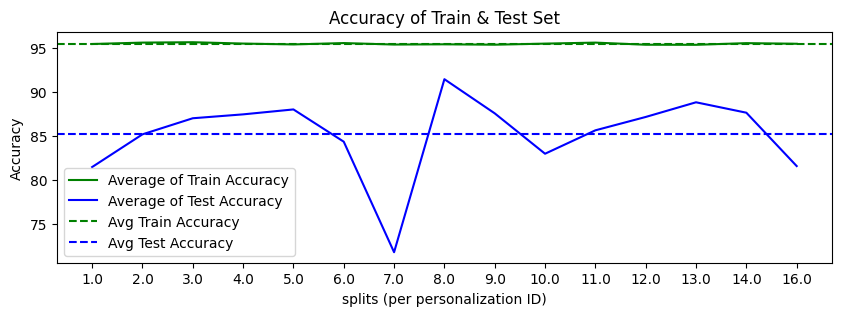

In [18]:
# 그래프 그리기
plt.figure(figsize=(10, 3))
plt.plot(eval_df['id'], eval_df['train_acc'], 'g', label='Average of Train Accuracy')
plt.plot(eval_df['id'], eval_df['test_acc'], 'b', label='Average of Test Accuracy')

# 가로 점선 추가
plt.axhline(y=avg_train_mape, color='g', linestyle='--', label='Avg Train Accuracy')
plt.axhline(y=avg_test_mape, color='b', linestyle='--', label='Avg Test Accuracy')

plt.title('Accuracy of Train & Test Set')
plt.xlabel('splits (per personalization ID)')
plt.ylabel('Accuracy')
plt.legend()

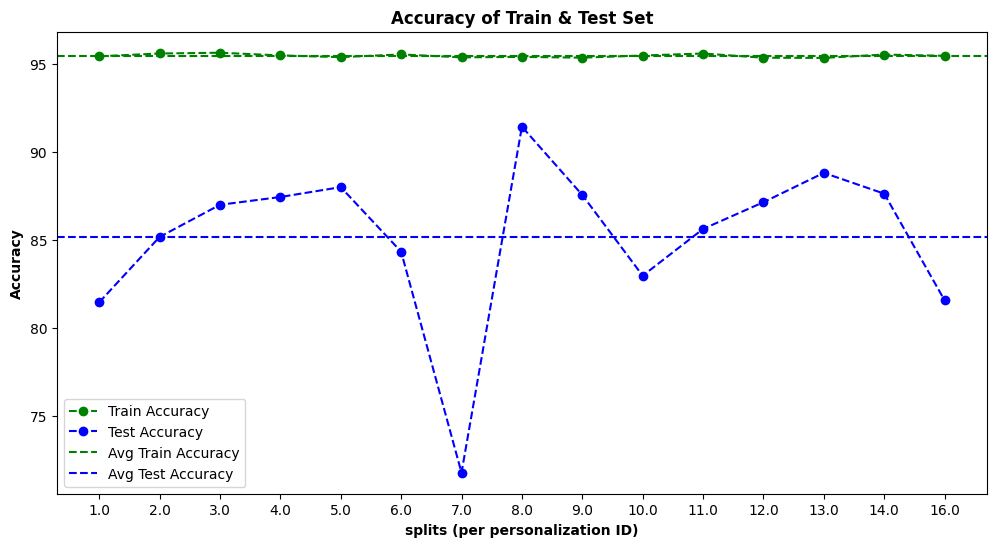

In [19]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(eval_df['id'], eval_df['train_acc'], 'go--', label='Train Accuracy')
plt.plot(eval_df['id'], eval_df['test_acc'], 'bo--', label='Test Accuracy')

# 가로 점선 추가 (평균값 표시)
plt.axhline(y=avg_train_mape, color='g', linestyle='--', label='Avg Train Accuracy')
plt.axhline(y=avg_test_mape, color='b', linestyle='--', label='Avg Test Accuracy')

# 레이블 및 제목 설정
plt.xlabel('splits (per personalization ID)', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy of Train & Test Set', fontweight='bold')
plt.xticks(eval_df['id'])

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

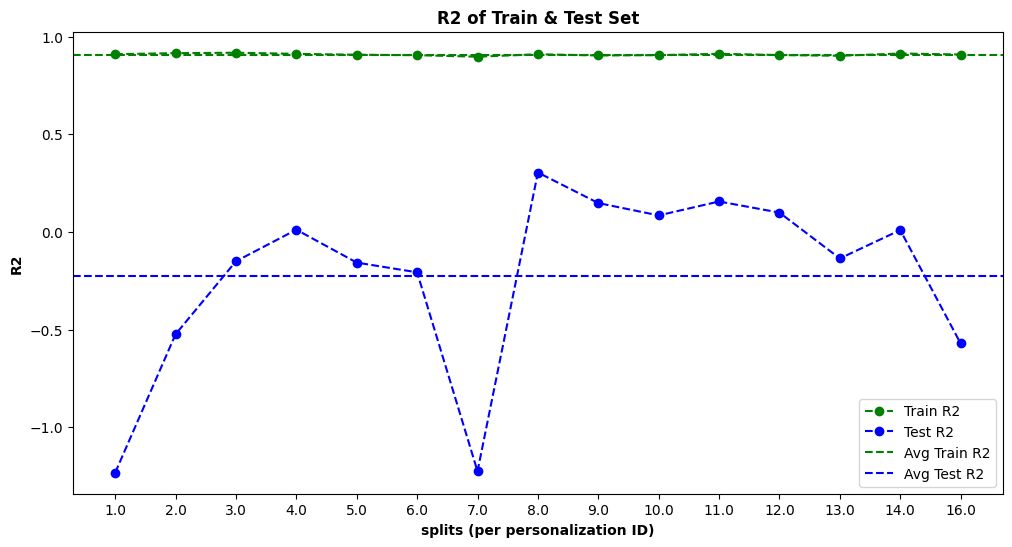

In [20]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(eval_df['id'], eval_df['train_r2'], 'go--', label='Train R2')
plt.plot(eval_df['id'], eval_df['test_r2'], 'bo--', label='Test R2')

# 가로 점선 추가 (평균값 표시)
plt.axhline(y=avg_train_r2, color='g', linestyle='--', label='Avg Train R2')
plt.axhline(y=avg_test_r2, color='b', linestyle='--', label='Avg Test R2')

# 레이블 및 제목 설정
plt.xlabel('splits (per personalization ID)', fontweight='bold')
plt.ylabel('R2', fontweight='bold')
plt.title('R2 of Train & Test Set', fontweight='bold')
plt.xticks(eval_df['id'])

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

/tmp/ipykernel_843/2107135607.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


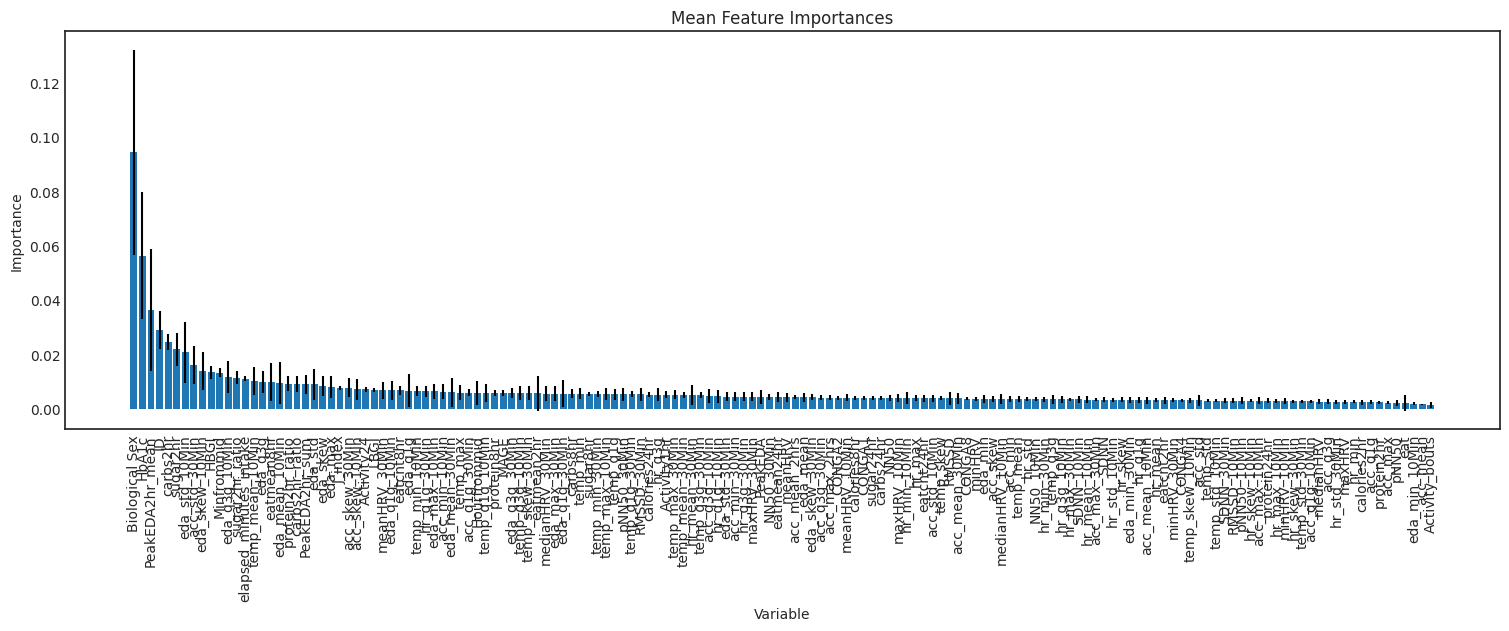

In [21]:
plt.style.use('seaborn-white')
plt.figure(figsize=(15, 6))
x_values = list(range(len(filteredimp['importances'])))
# Make a bar chart
plt.bar(x_values, filteredimp['importances'], orientation = 'vertical', yerr=filteredimp['std'])# Tick labels for x axis
plt.xticks(x_values, filteredimp.index, rotation='vertical')# Axis labels and title
plt.tight_layout()
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(('Mean Feature Importances'))
plt.show()

## 3. 부분 개인화 교차 검증(partial personalization cross-validation) Model

In [22]:
def XGBPartialPersonalization(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000, personalization_train_percent=0.5):
    """
        Intermediate function. 
    """
    # Get important features
    #listimportances = LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators)
    #filteredi = listimportances[listimportances['importances'] < fs]
    #filteredi = filteredi['value']
    
    LOOCV_O = int(float(ids))
    data.loc[:,idcolumn] = data.loc[:,idcolumn].apply(int)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')

    train_cnt = int(len(data_cv) * personalization_train_percent)
    person_split_train = data_cv.iloc[:train_cnt]
    person_split_test = data_cv.iloc[train_cnt:]
    
    # Test data - the person left out of training
    data_test = person_split_test
    data_test = data_test.drop(columns=dropcols)
    #data_test = data_test.drop(columns=filteredi) #cvf
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable

    #X_test.loc[:, idcolumn] = X_test.loc[:, idcolumn].astype(pd.to_numeric)
    
    # Train data - all other people in dataframe
    data_filtered = pd.concat([person_split_train, data_filtered], ignore_index=True)
    data_train = data_filtered.drop(columns=dropcols)
    #data_train = data_train.drop(columns=filteredi)
    X_train = data_train.drop(columns=[outcomevar])

    feature_list = list(X_train.columns)
    #X_train= X_train
    y_train = data_train[outcomevar]

    #X_train.loc[:, idcolumn] = X_train.loc[:, idcolumn].astype(pd.to_numeric)


    # XGBoost Regressor with fixed parameters
    xgbr = xgb.XGBRegressor(
        n_estimators=numestimators,
        max_depth=6,
        learning_rate=0.1,
        random_state=0,
        enable_categorical=True
    )
    print('Now processing... XGBoost - Leave One Subject Out')
    xgbr.fit(X_train, y_train)
    
    test_predictions = xgbr.predict(X_test)
    train_predictions = xgbr.predict(X_train)
    errors = abs(test_predictions - y_test)

    # Root Mean Squared Error (RMSE)
    from sklearn import metrics
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, test_predictions))
    test_rmse = RMSE
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_predictions))
    
    # Mean Average Percent Error (MAPE)
    MAPerror = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100 
    test_mape = MAPerror
    train_mape = np.mean(np.abs((y_train - train_predictions) / y_train)) * 100 
    
    train_r2 = metrics.r2_score(y_train, train_predictions)
    test_r2 = metrics.r2_score(y_test, test_predictions)
    
    # List of tuples with variable and importance
    importances = list(xgbr.feature_importances_)
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    important['id'] = str(ids)
    
    return train_rmse, test_rmse, train_mape, test_mape, train_r2, test_r2, errors, RMSE, MAPerror, test_r2, important

def partialPersonalizationXGB(data, idcolumn, outcomevar, dropcols=[], numestimators=1000, personalization_train_percent = 0.5):
    """
        Main LOSO XGB function that calls other functions to do XGB training, and testing. 

        Args:
          
        Returns:
    """
    
    # Make list of all ID's in idcolumn
    IDlist = list(data[idcolumn].astype(str).unique())
    print(f'IDlist : {IDlist}')
    drop = [] #drop = [idcolumn]
    drop = drop + dropcols
    
    # Initialize empty lists and dataframe 
    errors = []
    rmse = []
    mape = []
    r2_list = []
    importances = pd.DataFrame(columns=['value', 'importances', 'id'])
    rmse_df = pd.DataFrame(columns=['train_rmse','test_rmse', 'id'])
    mape_df = pd.DataFrame(columns=['train_mape','test_mape', 'id'])
    acc_df = pd.DataFrame(columns=['train_acc','test_acc', 'id'])
    r2_df = pd.DataFrame(columns=['train_r2','test_r2', 'id'])
    
    # Run LOOCV Random Forest! 
    for i in IDlist:
        train_rmse, test_rmse, train_mape, test_mape, train_r2, test_r2, er, rm, ma, r2, imp= XGBPartialPersonalization(data, i, outcomevar, drop, idcolumn, numestimators, personalization_train_percent)
        rmse_row = pd.DataFrame({'train_rmse': [train_rmse], 'test_rmse': [test_rmse], 'id': [str(i)]})
        rmse_df = pd.concat([rmse_df, rmse_row], ignore_index=True)
        mape_row = pd.DataFrame({'train_mape': [train_mape], 'test_mape': [test_mape], 'id': [str(i)]})
        mape_df = pd.concat([mape_df, mape_row], ignore_index=True)
        acc_row = pd.DataFrame({'train_acc': [100 - train_mape], 'test_acc': [100 - test_mape], 'id': [str(i)]})
        acc_df = pd.concat([acc_df, acc_row], ignore_index=True)
        r2_row = pd.DataFrame({'train_r2': [train_r2], 'test_r2': [test_r2], 'id': [str(i)]})
        r2_df = pd.concat([r2_df, r2_row], ignore_index=True)
        errors.append(er)
        rmse.append(rm)
        mape.append(ma)
        r2_list.append(r2)
        #eval = pd.DataFrame({'rmse': [rm], 'mape': [ma], 'id': [str(i)]})
        #eval_metrics = pd.concat([eval_metrics, eval], ignore_index=True)
        importances = pd.concat([importances, imp], ignore_index=True)
        idt = str(i)
        print('...' + idt + ' processing complete.')

    # Compute mean and std RMSE, MAPE
    # Compute mean and std RMSE, MAPE
    meanrmse = np.mean(rmse)
    stdrmse = np.std(rmse)
    meanmape = np.mean(mape)
    stdmape = np.std(mape)
    meanr2 = np.mean(r2_list)
    stdr2 = np.std(r2_list)
    
    # Print RMSE, MAPE
    print('Mean RMSE:' + str(meanrmse))
    print('Std RMSE:' + str(stdrmse))
    print('Mean MAPE:' + str(meanmape))
    print('Std MAPE:' + str(stdmape))
    print('Mean R2:' + str(meanr2))
    print('Std R2:' + str(stdr2))
    
    eval_df = rmse_df.merge(mape_df, on='id').merge(acc_df, on='id').merge(r2_df, on='id')
    
    #TODO: 파라미터들을 담은 dataframe을 반환하도록 할 것.
    return eval_df, errors, meanrmse, stdrmse, meanmape, stdmape, importances

In [23]:
eval_df, errors, RMSE, RMSEstd, MAPE, MAPEstd, importances = partialPersonalizationXGB(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'], numestimators=100)

IDlist : ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '16.0']
LOOCV_O : 1
Now processing... XGBoost - Leave One Subject Out


/tmp/ipykernel_843/820396079.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmse_df = pd.concat([rmse_df, rmse_row], ignore_index=True)
/tmp/ipykernel_843/820396079.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mape_df = pd.concat([mape_df, mape_row], ignore_index=True)
/tmp/ipykernel_843/820396079.py:115: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when 

...1.0 processing complete.
LOOCV_O : 2
Now processing... XGBoost - Leave One Subject Out
...2.0 processing complete.
LOOCV_O : 3
Now processing... XGBoost - Leave One Subject Out
...3.0 processing complete.
LOOCV_O : 4
Now processing... XGBoost - Leave One Subject Out
...4.0 processing complete.
LOOCV_O : 5
Now processing... XGBoost - Leave One Subject Out
...5.0 processing complete.
LOOCV_O : 6
Now processing... XGBoost - Leave One Subject Out
...6.0 processing complete.
LOOCV_O : 7
Now processing... XGBoost - Leave One Subject Out
...7.0 processing complete.
LOOCV_O : 8
Now processing... XGBoost - Leave One Subject Out
...8.0 processing complete.
LOOCV_O : 9
Now processing... XGBoost - Leave One Subject Out
...9.0 processing complete.
LOOCV_O : 10
Now processing... XGBoost - Leave One Subject Out
...10.0 processing complete.
LOOCV_O : 11
Now processing... XGBoost - Leave One Subject Out
...11.0 processing complete.
LOOCV_O : 12
Now processing... XGBoost - Leave One Subject Out
...12

In [24]:
eval_df.head(20)

,train_rmse,test_rmse,id,train_mape,test_mape,train_acc,test_acc,train_r2,test_r2
0,7.395197,13.278874,1.0,4.725584,8.648967,95.274416,91.351033,0.901660,0.054717
1,7.046189,20.731097,2.0,4.547999,12.671219,95.452001,87.328781,0.907696,0.029106
2,7.334427,12.618561,3.0,4.714123,8.754744,95.285877,91.245256,0.902669,0.057568
3,7.234087,17.070061,4.0,4.645584,10.851248,95.354416,89.148752,0.904793,0.112160
4,7.194220,12.660530,5.0,4.623065,10.592204,95.376935,89.407796,0.905678,0.271573
5,7.072213,29.358761,6.0,4.560850,14.351157,95.439150,85.648843,0.903023,0.146793
6,7.055988,22.786753,7.0,4.548689,22.210620,95.451311,77.789380,0.905110,-0.226710
7,7.064287,13.924107,8.0,4.580154,9.160330,95.419846,90.839670,0.909810,0.257759
8,7.081430,19.944254,9.0,4.543455,10.767990,95.456545,89.232010,0.906194,0.371670
9,6.973016,29.936012,10.0,4.467896,16.894207,95.532104,83.105793,0.907399,0.160918


In [25]:
# Compute average of RMSE
avg_train_rmse = eval_df['train_rmse'].mean()
avg_test_rmse = eval_df['test_rmse'].mean()
# Compute average of MAPE
avg_train_mape = eval_df['train_acc'].mean()
avg_test_mape = eval_df['test_acc'].mean()

In [26]:
imp_err = importances.groupby('value').std(numeric_only=True).rename(columns={'importances':'std'})

In [27]:
filteredimp = importances.groupby('value').mean(numeric_only=True).sort_values(by='importances', ascending=False)
filteredimp = pd.merge(filteredimp, imp_err, on='value')
print(filteredimp)

                 importances       std
value                                 
Biological Sex      0.093568  0.029437
HbA1c               0.051129  0.018808
PeakEDA2hr_mean     0.044596  0.023173
ID                  0.027891  0.006308
eda_std_10Min       0.024712  0.009051
...                      ...       ...
maxHRV              0.002188  0.000703
hr_min              0.002178  0.000530
acc_mean            0.001461  0.000284
eat                 0.001338  0.001334
Activity_bouts      0.001193  0.001681

[152 rows x 2 columns]


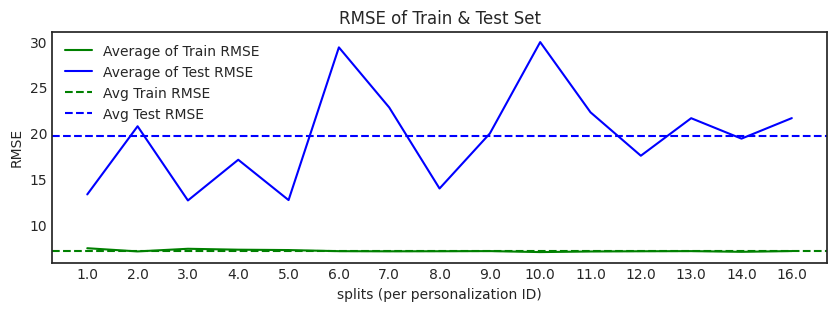

In [28]:
# 그래프 그리기
plt.figure(figsize=(10, 3))
plt.plot(eval_df['id'], eval_df['train_rmse'], 'g', label='Average of Train RMSE')
plt.plot(eval_df['id'], eval_df['test_rmse'], 'b', label='Average of Test RMSE')

# 가로 점선 추가
plt.axhline(y=avg_train_rmse, color='g', linestyle='--', label='Avg Train RMSE')
plt.axhline(y=avg_test_rmse, color='b', linestyle='--', label='Avg Test RMSE')

plt.title('RMSE of Train & Test Set')
plt.xlabel('splits (per personalization ID)')
plt.ylabel('RMSE')
plt.legend()

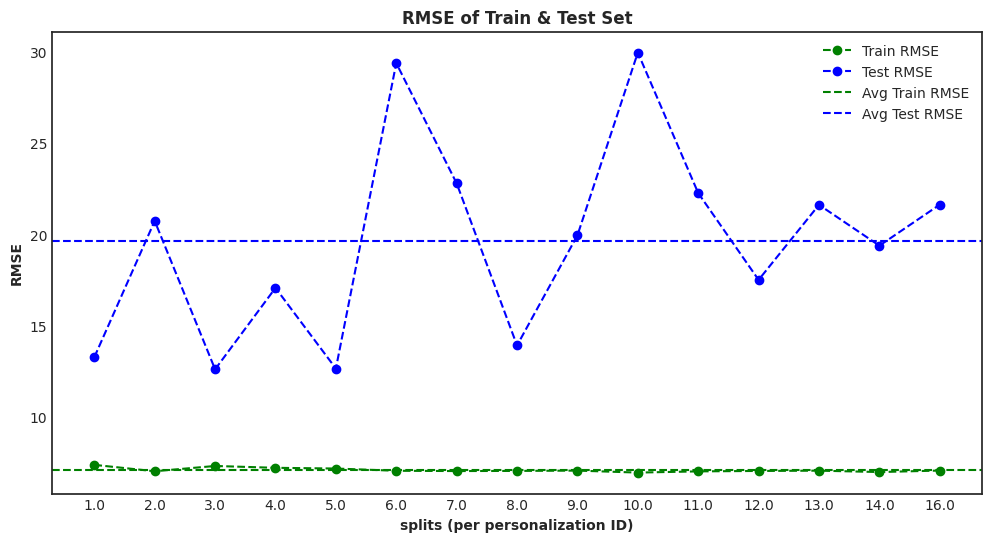

In [29]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(eval_df['id'], eval_df['train_rmse'], 'go--', label='Train RMSE')
plt.plot(eval_df['id'], eval_df['test_rmse'], 'bo--', label='Test RMSE')

# 가로 점선 추가 (평균값 표시)
plt.axhline(y=avg_train_rmse, color='g', linestyle='--', label='Avg Train RMSE')
plt.axhline(y=avg_test_rmse, color='b', linestyle='--', label='Avg Test RMSE')

# 레이블 및 제목 설정
plt.xlabel('splits (per personalization ID)', fontweight='bold')
plt.ylabel('RMSE', fontweight='bold')
plt.title('RMSE of Train & Test Set', fontweight='bold')
plt.xticks(eval_df['id'])

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()


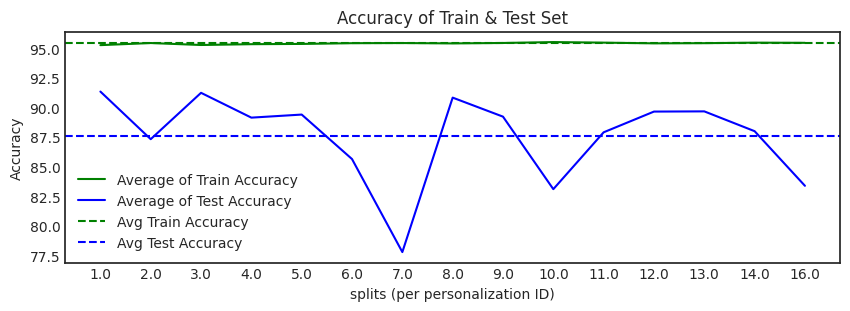

In [30]:
# 그래프 그리기
plt.figure(figsize=(10, 3))
plt.plot(eval_df['id'], eval_df['train_acc'], 'g', label='Average of Train Accuracy')
plt.plot(eval_df['id'], eval_df['test_acc'], 'b', label='Average of Test Accuracy')

# 가로 점선 추가
plt.axhline(y=avg_train_mape, color='g', linestyle='--', label='Avg Train Accuracy')
plt.axhline(y=avg_test_mape, color='b', linestyle='--', label='Avg Test Accuracy')

plt.title('Accuracy of Train & Test Set')
plt.xlabel('splits (per personalization ID)')
plt.ylabel('Accuracy')
plt.legend()

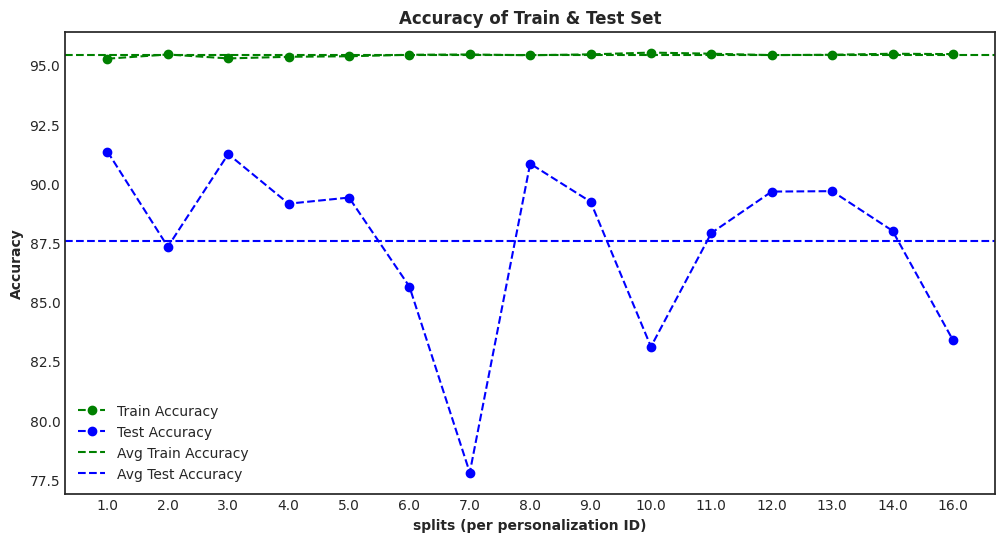

In [31]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(eval_df['id'], eval_df['train_acc'], 'go--', label='Train Accuracy')
plt.plot(eval_df['id'], eval_df['test_acc'], 'bo--', label='Test Accuracy')

# 가로 점선 추가 (평균값 표시)
plt.axhline(y=avg_train_mape, color='g', linestyle='--', label='Avg Train Accuracy')
plt.axhline(y=avg_test_mape, color='b', linestyle='--', label='Avg Test Accuracy')

# 레이블 및 제목 설정
plt.xlabel('splits (per personalization ID)', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy of Train & Test Set', fontweight='bold')
plt.xticks(eval_df['id'])

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()


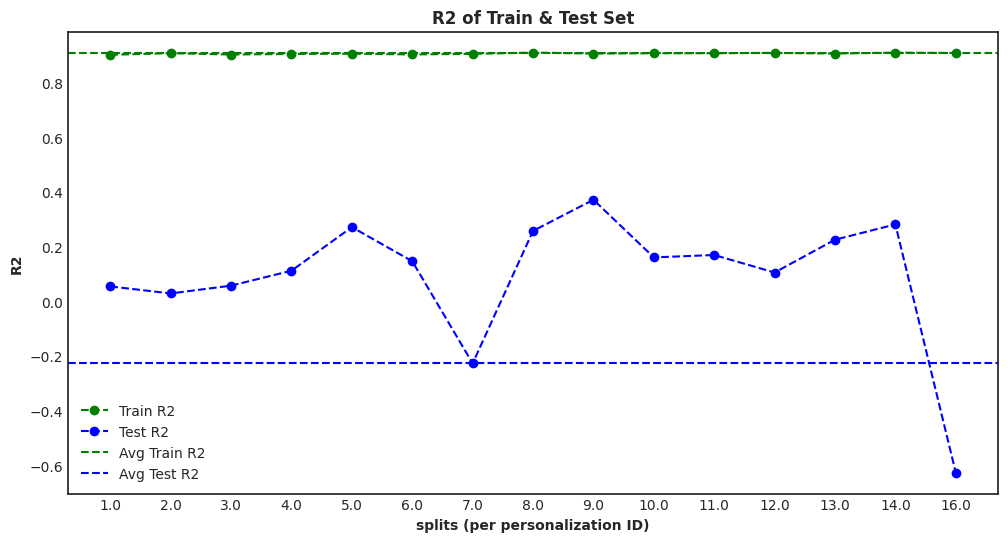

In [32]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(eval_df['id'], eval_df['train_r2'], 'go--', label='Train R2')
plt.plot(eval_df['id'], eval_df['test_r2'], 'bo--', label='Test R2')

# 가로 점선 추가 (평균값 표시)
plt.axhline(y=avg_train_r2, color='g', linestyle='--', label='Avg Train R2')
plt.axhline(y=avg_test_r2, color='b', linestyle='--', label='Avg Test R2')

# 레이블 및 제목 설정
plt.xlabel('splits (per personalization ID)', fontweight='bold')
plt.ylabel('R2', fontweight='bold')
plt.title('R2 of Train & Test Set', fontweight='bold')
plt.xticks(eval_df['id'])

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()